In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
data = pd.read_hdf('./classifier_training_data_shap.h5', 'final_df')  
data.head()

,Sentence_Class,Predictions,Tag,SHAP,SHAP_Base
0,"[1, 0]","[1.0, 0.0]",O,-0.293217,8.905662
1,"[1, 0]","[1.0, 0.0]",T,-0.885153,8.905662
2,"[1, 0]","[1.0, 0.0]",T,-0.808605,8.905662
3,"[1, 0]","[1.0, 0.0]",T,-0.969538,8.905662
4,"[1, 0]","[1.0, 0.0]",T,-0.873174,8.905662


<AxesSubplot:xlabel='Tag', ylabel='count'>

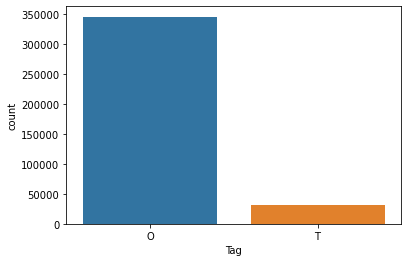

In [3]:
sns.countplot(x = 'Tag', data=data)

In [4]:
backup = data

In [5]:
# o_data = data[data['Tag']=='O'].sample(93693, random_state=55)
# t_data = data[data['Tag']=='T']
# frames = [o_data, t_data]
# data = pd.concat(frames)

In [6]:
# g = data.groupby('Tag')
# g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))

In [7]:
o_data = data.loc[data['Tag']=='O'].sample(62462, random_state=55)#93693 
t_data = data.loc[data['Tag']=='T']

In [8]:
data = pd.concat([o_data, t_data])

In [9]:
data = data.reset_index(drop=True)

In [10]:
from sklearn.utils import shuffle
data = shuffle(data, random_state=55)
print(data)

      Sentence_Class Predictions Tag      SHAP  SHAP_Base
17256         [1, 0]  [0.0, 1.0]   O  0.379888   8.984762
54826         [1, 0]  [1.0, 0.0]   O -0.055352   9.418741
61600         [1, 0]  [0.0, 1.0]   O  0.008017   8.280604
6305          [1, 0]  [1.0, 0.0]   O -0.135073   9.154434
84025         [1, 0]  [1.0, 0.0]   T -0.112723   9.004463
...              ...         ...  ..       ...        ...
10213         [0, 1]  [1.0, 0.0]   O -0.218944   9.092147
16253         [1, 0]  [1.0, 0.0]   O  0.007997   8.917603
82888         [1, 0]  [0.0, 1.0]   T -0.322588   9.004463
28967         [1, 0]  [0.0, 1.0]   O  0.078436   9.092147
4762          [1, 0]  [1.0, 0.0]   O -0.259393   8.887365

[93693 rows x 5 columns]


<AxesSubplot:xlabel='Tag', ylabel='count'>

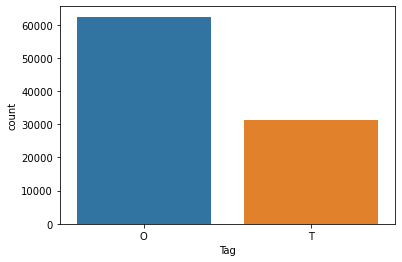

In [11]:
sns.countplot(x = 'Tag', data=data)

In [12]:
data['Tag'] = data['Tag'].astype('category')
encode_map = {
    'T': 1,
    'O': 0
}
data['Tag'] .replace(encode_map, inplace=True)

In [13]:
data['toxic_sentence'] = data['Predictions'].apply(lambda x: 0 if x == [0.0,1.0] else 1) 
data['non_toxic_sentence'] = data['Predictions'].apply(lambda x: 1 if x == [0.0,1.0] else 0) 

In [14]:
data.head(1)

,Sentence_Class,Predictions,Tag,SHAP,SHAP_Base,toxic_sentence,non_toxic_sentence
17256,"[1, 0]","[0.0, 1.0]",0,0.379888,8.984762,0,1


In [15]:
data.drop(columns = ['Sentence_Class','Predictions'])

,Tag,SHAP,SHAP_Base,toxic_sentence,non_toxic_sentence
17256,0,0.379888,8.984762,0,1
54826,0,-0.055352,9.418741,1,0
61600,0,0.008017,8.280604,0,1
6305,0,-0.135073,9.154434,1,0
84025,1,-0.112723,9.004463,1,0
...,...,...,...,...,...
10213,0,-0.218944,9.092147,1,0
16253,0,0.007997,8.917603,1,0
82888,1,-0.322588,9.004463,0,1
28967,0,0.078436,9.092147,0,1


In [16]:
cols = ['SHAP','SHAP_Base','toxic_sentence','non_toxic_sentence','Tag']
data= data[cols]
data.head(1)

,SHAP,SHAP_Base,toxic_sentence,non_toxic_sentence,Tag
17256,0.379888,8.984762,0,1,0


In [17]:
df = data

In [18]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=69)

In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 0.00001

In [22]:
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test))

In [23]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [24]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(4, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [26]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=4, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [27]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [28]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.61964 | Acc: 67.150
Epoch 002: | Loss: 0.57449 | Acc: 73.459
Epoch 003: | Loss: 0.56091 | Acc: 74.410
Epoch 004: | Loss: 0.55215 | Acc: 74.958
Epoch 005: | Loss: 0.54825 | Acc: 75.095
Epoch 006: | Loss: 0.54457 | Acc: 75.285
Epoch 007: | Loss: 0.54207 | Acc: 75.225
Epoch 008: | Loss: 0.54044 | Acc: 75.404
Epoch 009: | Loss: 0.53905 | Acc: 75.396
Epoch 010: | Loss: 0.53763 | Acc: 75.407
Epoch 011: | Loss: 0.53647 | Acc: 75.501
Epoch 012: | Loss: 0.53592 | Acc: 75.491
Epoch 013: | Loss: 0.53547 | Acc: 75.430
Epoch 014: | Loss: 0.53571 | Acc: 75.409
Epoch 015: | Loss: 0.53550 | Acc: 75.373
Epoch 016: | Loss: 0.53420 | Acc: 75.495
Epoch 017: | Loss: 0.53348 | Acc: 75.521
Epoch 018: | Loss: 0.53335 | Acc: 75.474
Epoch 019: | Loss: 0.53314 | Acc: 75.451
Epoch 020: | Loss: 0.53352 | Acc: 75.417


In [29]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [30]:
confusion_matrix(y_test, y_pred_list)

array([[6033,  287],
       [1905, 1145]], dtype=int64)

In [31]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.76      0.95      0.85      6320
           1       0.80      0.38      0.51      3050

    accuracy                           0.77      9370
   macro avg       0.78      0.66      0.68      9370
weighted avg       0.77      0.77      0.74      9370



In [32]:
import sklearn
sklearn.metrics.f1_score(y_test, y_pred_list,pos_label= 1 )

0.5109326193663544

In [36]:
torch.save(model.state_dict(), 'shap_model1.pth')